In [1]:
import time

In [2]:
import os
import zipfile
import urllib.request
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.io import arff
import torch
from torch.utils.data import TensorDataset, DataLoader

# Directory where datasets will be downloaded and extracted
DATA_DIR = 'datasets'

# Ensure the dataset directory exists
os.makedirs(DATA_DIR, exist_ok=True)

def download_dataset(dataset_name, url):
    """
    Downloads and extracts a zip file containing the dataset.
    """
    zip_path = os.path.join(DATA_DIR, f"{dataset_name}.zip")
    extract_path = os.path.join(DATA_DIR, dataset_name)

    # Download the dataset
    print(f"Downloading {dataset_name} from {url}...")
    urllib.request.urlretrieve(url, zip_path)

    # Extract the zip file
    print(f"Extracting {dataset_name}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    # Remove the zip file after extraction
    os.remove(zip_path)
    print(f"Dataset {dataset_name} extracted to {extract_path}.")
    return extract_path

def load_arff_data(file_path):
    """
    Loads ARFF file and converts it to a pandas DataFrame.
    """
    print(f"Loading ARFF file: {file_path}")
    data, meta = arff.loadarff(file_path)
    df = pd.DataFrame(data)
    return df

def preprocess_data(train_df, test_df, batch_size=64):
    """
    Preprocesses the data:
    - Splits the features and labels.
    - Normalizes the features.
    - Converts them into PyTorch tensors.
    - Creates DataLoaders for training, validation, and testing.
    """
    # Separate features and labels
    train_features = train_df.drop(columns=['target'])
    test_features = test_df.drop(columns=['target'])

    train_labels = train_df['target'].apply(lambda x: int(x)).values
    test_labels = test_df['target'].apply(lambda x: int(x)).values

    # Normalize features
    scaler = StandardScaler()
    train_features_normalized = scaler.fit_transform(train_features)
    test_features_normalized = scaler.transform(test_features)

    # Reshape the features into 3D arrays (samples, time_steps, dimensions)
    X_train = train_features_normalized.reshape(-1, 96, 1)
    X_test = test_features_normalized.reshape(-1, 96, 1)

    # Split test data into validation and test sets
    X_valid, X_test, y_valid, y_test = train_test_split(X_test, test_labels, test_size=0.50, random_state=42)

    # Convert data to PyTorch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(train_labels, dtype=torch.int64)

    X_valid = torch.tensor(X_valid, dtype=torch.float32)
    y_valid = torch.tensor(y_valid, dtype=torch.int64)

    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.int64)

    # Output dataset shapes
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_valid shape: {X_valid.shape}, y_valid shape: {y_valid.shape}")
    print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

    # Create DataLoaders
    train_dataset = TensorDataset(X_train, y_train)
    valid_dataset = TensorDataset(X_valid, y_valid)
    test_dataset = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    return train_loader, valid_loader, test_loader, len(np.unique(train_labels))

# Example usage for downloading, extracting, and preprocessing the ElectricDevices dataset
if __name__ == "__main__":
    # URL for the dataset (replace with the actual dataset you want to download)
    dataset_name = 'ElectricDevices'  # Replace with your dataset name
    dataset_url = 'https://timeseriesclassification.com/aeon-toolkit/ElectricDevices.zip'

    # Download and extract the dataset
    extract_path = download_dataset(dataset_name, dataset_url)

    # Load ARFF data
    train_file = os.path.join(extract_path, f'{dataset_name}_TRAIN.arff')
    test_file = os.path.join(extract_path, f'{dataset_name}_TEST.arff')

    # Load data into Pandas DataFrames
    train_df = load_arff_data(train_file)
    test_df = load_arff_data(test_file)

    # Preprocess the data
    train_loader, valid_loader, test_loader, n_classes = preprocess_data(train_df, test_df)

    # Output the number of classes
    print(f"Number of classes: {n_classes}")


Extracting ElectricDevices...
Dataset ElectricDevices extracted to datasets/ElectricDevices.
Loading ARFF file: datasets/ElectricDevices/ElectricDevices_TRAIN.arff
Loading ARFF file: datasets/ElectricDevices/ElectricDevices_TEST.arff
X_train shape: torch.Size([8926, 96, 1]), y_train shape: torch.Size([8926])
X_valid shape: torch.Size([3855, 96, 1]), y_valid shape: torch.Size([3855])
X_test shape: torch.Size([3856, 96, 1]), y_test shape: torch.Size([3856])
Number of classes: 7


In [3]:
import os
import zipfile
import urllib.request
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.io import arff

DATA_DIR = 'datasets'
os.makedirs(DATA_DIR, exist_ok=True)

def download_dataset(dataset_name, url):
    zip_path    = os.path.join(DATA_DIR, f"{dataset_name}.zip")
    extract_dir = os.path.join(DATA_DIR, dataset_name)
    urllib.request.urlretrieve(url, zip_path)
    with zipfile.ZipFile(zip_path, 'r') as zp:
        zp.extractall(extract_dir)
    os.remove(zip_path)
    return extract_dir

def load_arff_data(file_path):
    raw, meta = arff.loadarff(file_path)
    return pd.DataFrame(raw)

def preprocess_data(train_df, test_df, valid_size=0.5, random_state=42):
    # --- 1) Separate features & labels ---
    X_train_df = train_df.drop(columns=['target'])
    y_train_df = train_df['target'].astype(int)

    X_temp_df  = test_df.drop(columns=['target'])
    y_temp_df  = test_df['target'].astype(int)

    # --- 2) Split temp into validation & test ---
    X_valid_df, X_test_df, y_valid_df, y_test_df = train_test_split(
        X_temp_df, y_temp_df,
        test_size=valid_size,
        random_state=random_state,
        stratify=y_temp_df
    )

    # --- 3) Normalize all features (fit on train only) ---
    scaler = StandardScaler().fit(X_train_df)
    X_train_df = pd.DataFrame(
        scaler.transform(X_train_df),
        columns=X_train_df.columns,
        index=X_train_df.index
    )
    X_valid_df = pd.DataFrame(
        scaler.transform(X_valid_df),
        columns=X_valid_df.columns,
        index=X_valid_df.index
    )
    X_test_df = pd.DataFrame(
        scaler.transform(X_test_df),
        columns=X_test_df.columns,
        index=X_test_df.index
    )

    # --- 4) Return six DataFrames/Series ---
    return X_train_df, y_train_df, X_valid_df, y_valid_df, X_test_df, y_test_df

if __name__ == "__main__":
    dataset_name = 'ElectricDevices'
    url = 'https://timeseriesclassification.com/aeon-toolkit/ElectricDevices.zip'

    path = download_dataset(dataset_name, url)
    train_df = load_arff_data(os.path.join(path, f"{dataset_name}_TRAIN.arff"))
    test_df  = load_arff_data(os.path.join(path, f"{dataset_name}_TEST.arff"))

    X_train, y_train, X_valid, y_valid, X_test, y_test = preprocess_data(train_df, test_df)

    print("Shapes:")
    print("  X_train:", X_train.shape, " y_train:", y_train.shape)
    print("  X_valid:", X_valid.shape, " y_valid:", y_valid.shape)
    print("  X_test: ", X_test.shape,  " y_test: ", y_test.shape)


Shapes:
  X_train: (8926, 96)  y_train: (8926,)
  X_valid: (3855, 96)  y_valid: (3855,)
  X_test:  (3856, 96)  y_test:  (3856,)


In [14]:
import embd_fgit as embd
import clasfy_p1 as clasfy
import clasfy_p2 as clasfy2
import plot_umap as plt_um
import pandas as pd
import numpy

In [15]:
#Performing scaling of the datasets
train_sc, val_sc, test_sc = embd.std_scaling(X_train, X_valid, X_test)
#without overlapping windows
train_sct=train_sc
test_sct=test_sc
val_sct=val_sc
ny_train=y_train
ny_test=y_test
ny_val=y_valid
ny_train2=y_train-1
ny_test2=y_test-1
ny_val2=y_valid-1


In [76]:
#pca embedding
t0 = time.perf_counter()
train_pca, val_pca, test_pca = embd.pca_embedding(train_sc, val_sc, test_sc,64)
t1 = time.perf_counter()
elapsed_ms = (t1 - t0) * 1000
print(f"nnclr_lstm_embedding took {elapsed_ms:.1f} ms")

nnclr_lstm_embedding took 25.5 ms


In [16]:
#to save your embeddings
np.savetxt('tr_ep_pca_embeddings.txt', train_pca)
np.savetxt('te_ep_pca_embeddings.txt', test_pca)
np.savetxt('vl_ep_pca_embeddings.txt', val_pca)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/content/plot_umap.py:23: UserWarning: 
The palette list has fewer values (5) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=ny_test.values.flatten(), palette=cp,s=50,hue_order=hue_order)


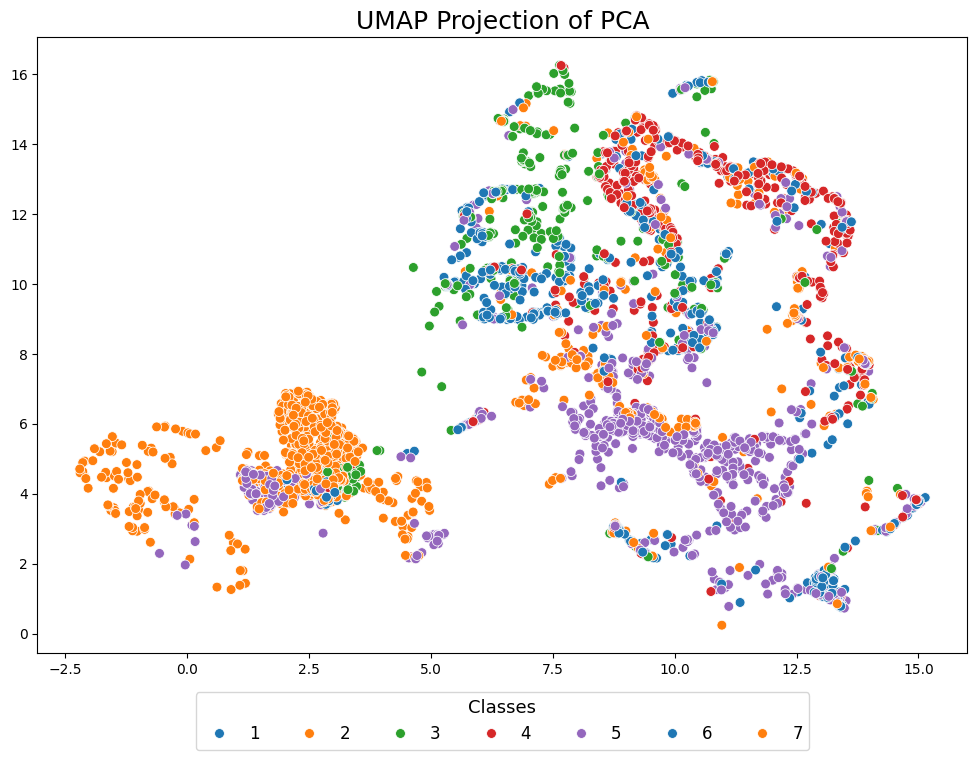

In [17]:
#to plot the umap visualization of the embedding
name='pca'
#to get the umap embedding
plt_um.umap_plt(train_pca, val_pca, test_pca, ny_train, ny_val, ny_test, 'PCA')

In [16]:
#discrete wavelet transform
t0 = time.perf_counter()
train_wt, val_wt, test_wt = embd.wavelet_embedding(train_sc, val_sc, test_sc)
t1 = time.perf_counter()
elapsed_ms = (t1 - t0) * 1000
print(f"nnclr_lstm_embedding took {elapsed_ms:.1f} ms")

nnclr_lstm_embedding took 14.2 ms


In [17]:
np.savetxt('tr_ep_wt_embeddings.txt', train_wt)
np.savetxt('te_ep_wt_embeddings.txt', test_wt)
np.savetxt('vl_ep_wt_embeddings.txt', val_wt)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/content/plot_umap.py:23: UserWarning: 
The palette list has fewer values (5) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=ny_test.values.flatten(), palette=cp,s=50,hue_order=hue_order)


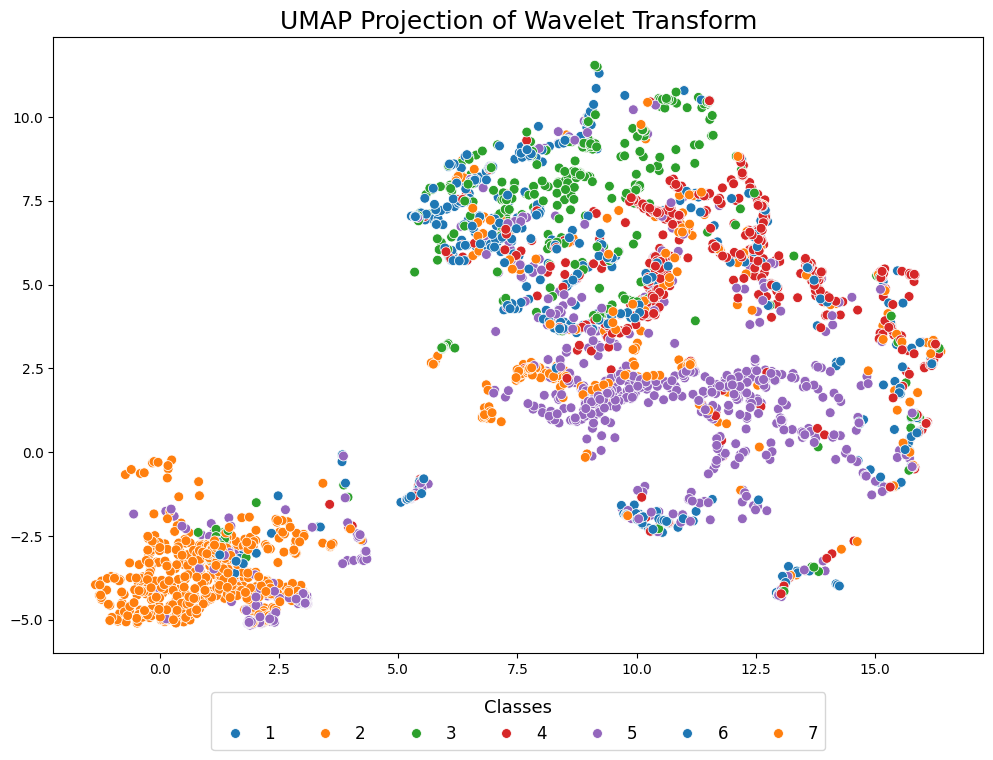

In [20]:
#to get the umap embedding
plt_um.umap_plt(train_wt, val_wt, test_wt, ny_train, ny_val, ny_test, 'Wavelet Transform')

In [78]:
#Fast Fourier Transform

t0 = time.perf_counter()
train_fft, val_fft, test_fft = embd.fft_embedding(train_sc, val_sc, test_sc)
t1 = time.perf_counter()
elapsed_ms = (t1 - t0) * 1000
print(f"nnclr_lstm_embedding took {elapsed_ms:.1f} ms")

nnclr_lstm_embedding took 210.6 ms


In [22]:
np.savetxt('tr_ep_fft_embeddings.txt', train_fft)
np.savetxt('te_ep_fft_embeddings.txt', test_fft)
np.savetxt('vl_ep_fft_embeddings.txt', val_fft)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/content/plot_umap.py:23: UserWarning: 
The palette list has fewer values (5) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=ny_test.values.flatten(), palette=cp,s=50,hue_order=hue_order)


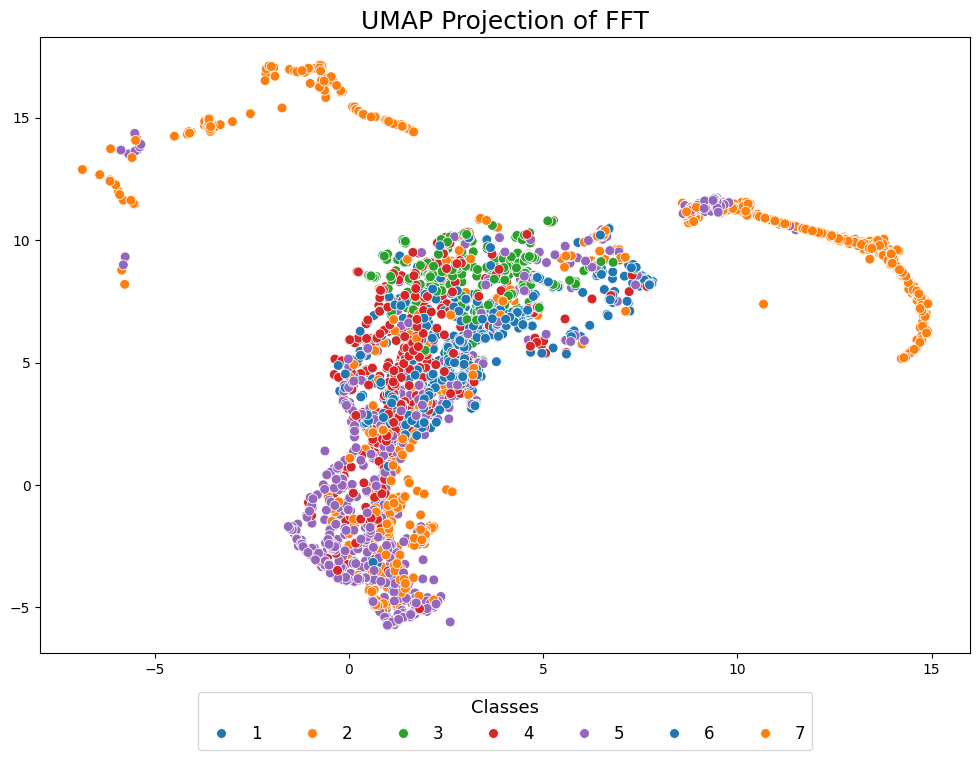

In [23]:
#to get the umap embedding
plt_um.umap_plt(train_fft, val_fft, test_fft, ny_train, ny_val, ny_test, 'FFT')

In [79]:
#Graph Embedding
#Based on the source paper and the algorithm discussed, this scaling method is used

t0 = time.perf_counter()
train_mmc, val_mmc,test_mmc = embd.minmax_scaling(X_train, X_valid,X_test)
train_mml=train_mmc.values.tolist()
val_mml=val_mmc.values.tolist()
test_mml=test_mmc.values.tolist()

train_gr, val_gr, test_gr = embd.graph_embedding(train_mml, val_mml, test_mml)
t1 = time.perf_counter()
elapsed_ms = (t1 - t0) * 1000
print(f"nnclr_lstm_embedding took {elapsed_ms:.1f} ms")

nnclr_lstm_embedding took 706169.5 ms


In [25]:
np.savetxt('tr_ep_gr_embeddings.txt', train_gr)
np.savetxt('te_ep_gr_embeddings.txt', test_gr)
np.savetxt('vl_ep_gr_embeddings.txt', val_gr)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/content/plot_umap.py:23: UserWarning: 
The palette list has fewer values (5) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=ny_test.values.flatten(), palette=cp,s=50,hue_order=hue_order)


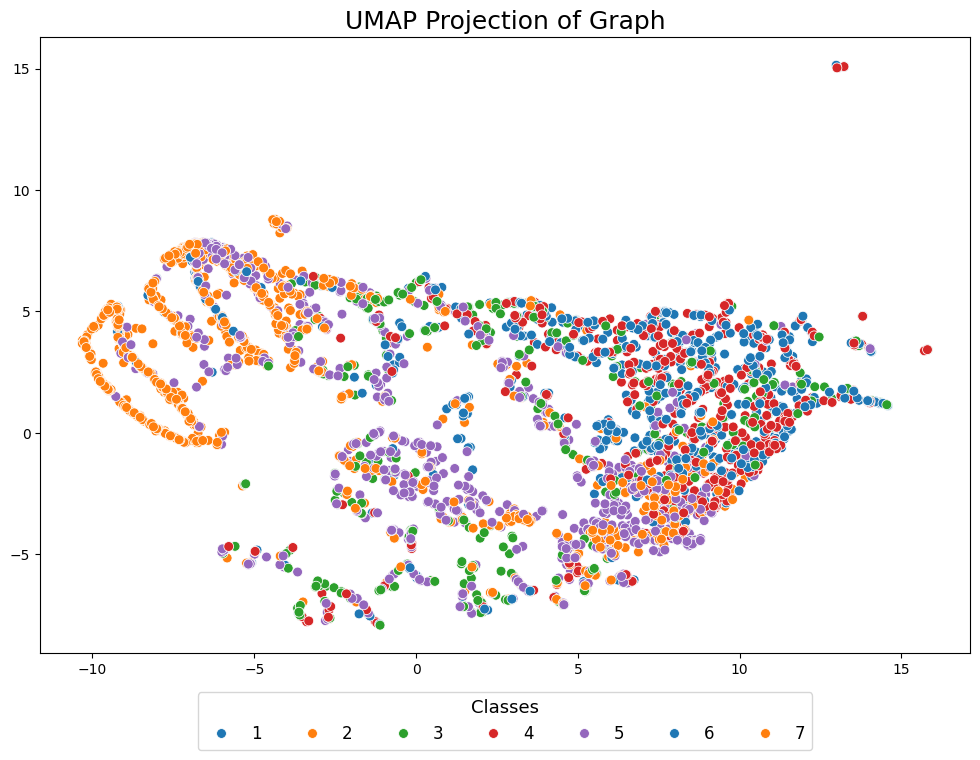

In [26]:
#to get the umap embedding
plt_um.umap_plt(train_gr, val_gr, test_gr, ny_train, ny_val, ny_test, 'Graph')

In [80]:
#TDA Embedding
t0 = time.perf_counter()
train_tda,val_tda,test_tda = embd.tda_embedding(train_mml, val_mml, test_mml)
t1 = time.perf_counter()
elapsed_ms = (t1 - t0) * 1000
print(f"nnclr_lstm_embedding took {elapsed_ms:.1f} ms")


nnclr_lstm_embedding took 412468.1 ms


In [28]:
np.savetxt('tr_ep_tda_embeddings.txt', train_tda)
np.savetxt('te_ep_tda_embeddings.txt', test_tda)
np.savetxt('vl_ep_tda_embeddings.txt', val_tda)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/content/plot_umap.py:23: UserWarning: 
The palette list has fewer values (5) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=ny_test.values.flatten(), palette=cp,s=50,hue_order=hue_order)


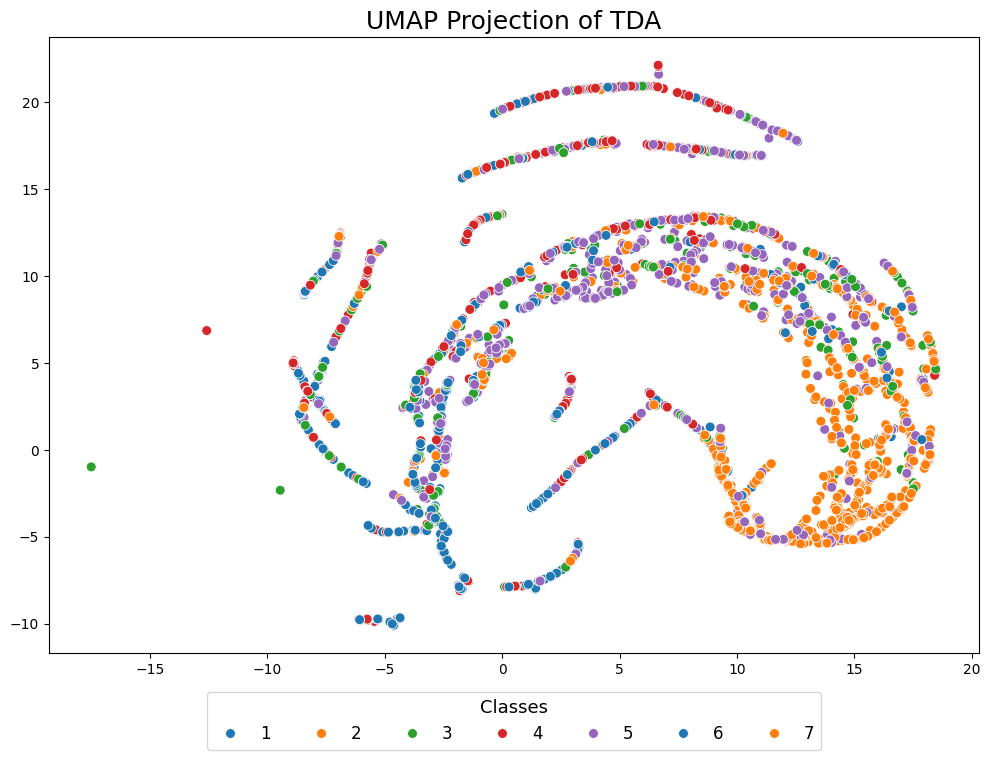

In [29]:
#to get the umap embedding
plt_um.umap_plt(train_tda,val_tda, test_tda, ny_train, ny_val, ny_test, 'TDA')

In [81]:
#LLE Embedding
t0 = time.perf_counter()
train_lle, val_lle, test_lle = embd.lle_embedding(train_sc, val_sc, test_sc,{'n_components':64, 'n_neighbors':5,'random_state':12})
t1 = time.perf_counter()
elapsed_ms = (t1 - t0) * 1000
print(f"nnclr_lstm_embedding took {elapsed_ms:.1f} ms")

nnclr_lstm_embedding took 92533.9 ms


In [31]:
np.savetxt('tr_ep_lle_embeddings.txt', train_lle)
np.savetxt('te_ep_lle_embeddings.txt', test_lle)
np.savetxt('vl_ep_lle_embeddings.txt', val_lle)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/content/plot_umap.py:23: UserWarning: 
The palette list has fewer values (5) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=ny_test.values.flatten(), palette=cp,s=50,hue_order=hue_order)


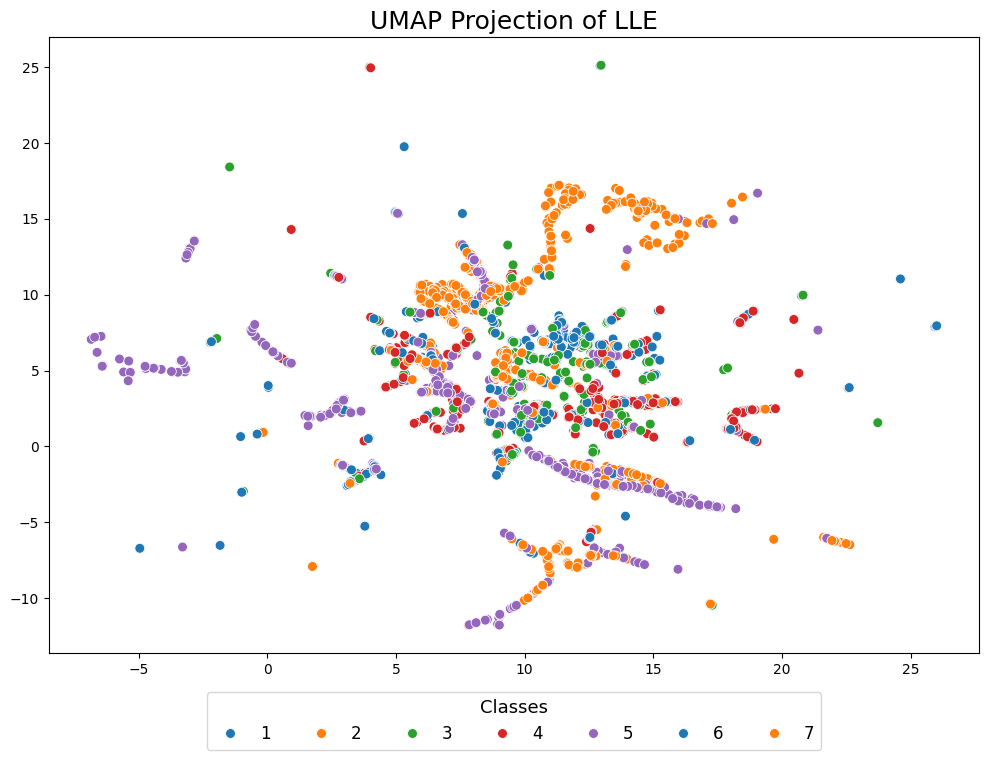

In [32]:
plt_um.umap_plt(train_lle, val_lle, test_lle, ny_train, ny_val, ny_test, 'LLE')

In [82]:
#UMAP Embedding
t0 = time.perf_counter()
train_umap, val_umap, test_umap = embd.umap_embedding(train_sc, val_sc, test_sc)
t1 = time.perf_counter()
elapsed_ms = (t1 - t0) * 1000
print(f"nnclr_lstm_embedding took {elapsed_ms:.1f} ms")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


nnclr_lstm_embedding took 14617.0 ms


In [34]:
np.savetxt('tr_ep_umap_embeddings.txt', train_umap)
np.savetxt('te_ep_umap_embeddings.txt', test_umap)
np.savetxt('vl_ep_umap_embeddings.txt', val_umap)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/content/plot_umap.py:23: UserWarning: 
The palette list has fewer values (5) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=ny_test.values.flatten(), palette=cp,s=50,hue_order=hue_order)


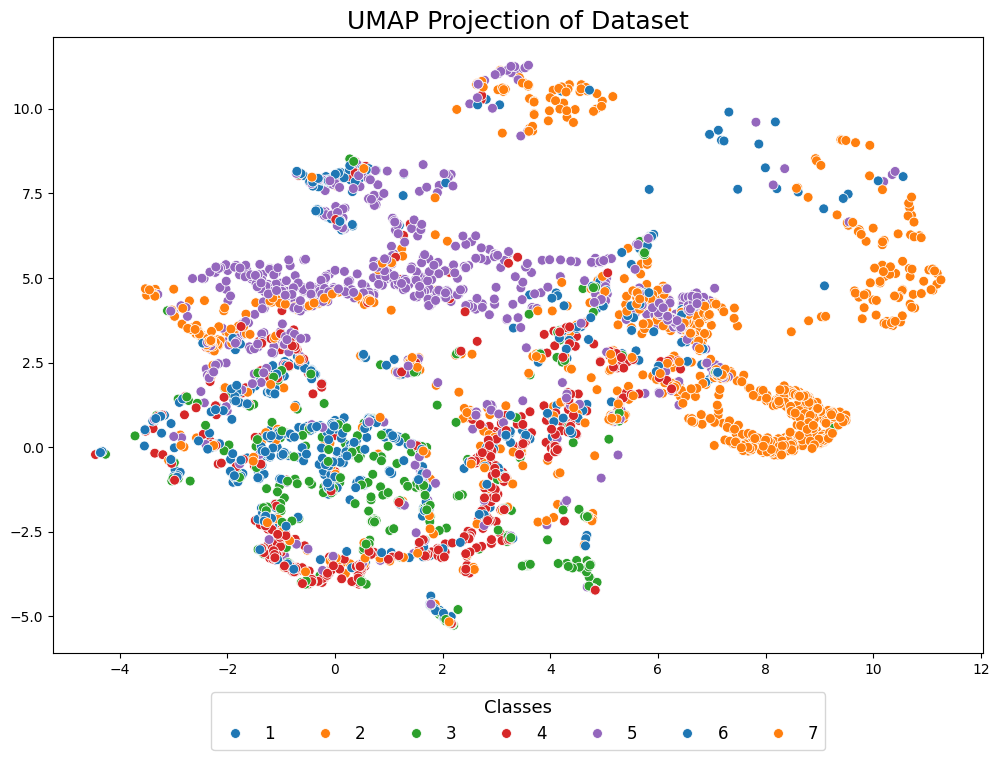

In [35]:
plt_um.umap_plt(train_sc, val_sc, test_sc, ny_train, ny_val, ny_test, 'Dataset')

In [83]:
#AE Embedding
t0 = time.perf_counter()
train_ae, val_ae, test_ae = embd.AE_embedding(train_sc, val_sc, test_sc)
t1 = time.perf_counter()
elapsed_ms = (t1 - t0) * 1000
print(f"nnclr_lstm_embedding took {elapsed_ms:.1f} ms")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
nnclr_lstm_embedding took 58850.6 ms


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/content/plot_umap.py:23: UserWarning: 
The palette list has fewer values (5) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=ny_test.values.flatten(), palette=cp,s=50,hue_order=hue_order)


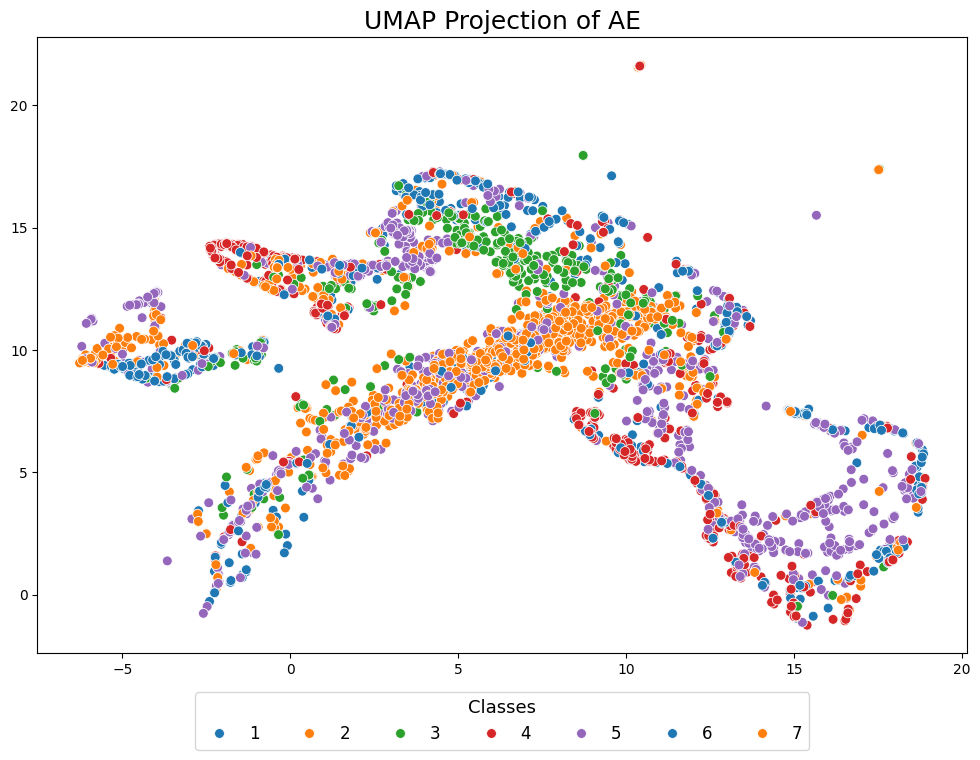

In [37]:
plt_um.umap_plt(train_ae, val_ae, test_ae, ny_train, ny_val, ny_test, 'AE')

In [38]:
np.savetxt('tr_ep_ae_embeddings.txt', train_ae)
np.savetxt('te_ep_ae_embeddings.txt', test_ae)
np.savetxt('vl_ep_ae_embeddings.txt', val_ae)

In [84]:
#nnclr_lstm embedding
#for the paper, 100 finetuning and training epochs were chosen, but here the example is done for 20 epochs
import nnclr_embd as nn
t0 = time.perf_counter()
train_nn_lstm, val_nn_lstm, test_nn_lstm = nn.nnclr_lstm_embedding(train_sc, val_sc, test_sc,y_train-1,y_valid-1,y_test-1,64,7)
t1 = time.perf_counter()
elapsed_ms = (t1 - t0) * 1000
print(f"nnclr_lstm_embedding took {elapsed_ms:.1f} ms")

x_train_df shape: (8926, 96)
y_train_df shape: (8926,)
x_val_df shape: (3855, 96)
y_val_df shape: (3855,)
x_test_df shape: (3856, 96)
y_test_df shape: (3856,)


Model: "encoder_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 96, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 96, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 96, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 96, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │         8,256 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 206,400 (806.25 KB)

 Trainable params: 206,400 (806.25 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "nnclr_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ contrastive_augmenter           │ (None, None, 1)        │             0 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_augmenter        │ (None, None, 1)        │             0 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_model (Sequential)      │ (None, 64)             │       206,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ projection_head (Sequential)    │ (None, 64)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ linear_probe (Sequential)       │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 215,175 (840.53 KB)

 Trainable params: 215,175 (840.53 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
121/121 - 11s - 93ms/step - c_acc: 0.0424 - c_loss: 3.4307 - p_acc: 0.2540 - p_loss: 1.8602 - r_acc: 0.0587 - val_p_acc: 0.2536 - val_p_loss: 1.8978
Epoch 2/20
121/121 - 4s - 29ms/step - c_acc: 0.0763 - c_loss: 3.0910 - p_acc: 0.2646 - p_loss: 1.7898 - r_acc: 0.1056 - val_p_acc: 0.2832 - val_p_loss: 1.8688
Epoch 3/20
121/121 - 6s - 47ms/step - c_acc: 0.1120 - c_loss: 3.0241 - p_acc: 0.3027 - p_loss: 1.7691 - r_acc: 0.1251 - val_p_acc: 0.2741 - val_p_loss: 1.8655
Epoch 4/20
121/121 - 4s - 34ms/step - c_acc: 0.1401 - c_loss: 2.6170 - p_acc: 0.3126 - p_loss: 1.7730 - r_acc: 0.1520 - val_p_acc: 0.2661 - val_p_loss: 1.8252
Epoch 5/20
121/121 - 4s - 29ms/step - c_acc: 0.1673 - c_loss: 2.7835 - p_acc: 0.3320 - p_loss: 1.6596 - r_acc: 0.1847 - val_p_acc: 0.3576 - val_p_loss: 1.7797
Epoch 6/20
121/121 - 4s - 35ms/step - c_acc: 0.1874 - c_loss: 2.4757 - p_acc: 0.3974 - p_loss: 1.6378 - r_acc: 0.2348 - val_p_acc: 0.4253 - val_p_loss: 1.7686
Epoch 7/20
121/121 - 4s - 29ms/step - c_

In [40]:
np.savetxt('tr_ep_nn_lstm_embeddings.txt', train_nn_lstm)
np.savetxt('te_ep_nn_lstm_embeddings.txt', test_nn_lstm)
np.savetxt('vl_ep_nn_lstm_embeddings.txt', val_nn_lstm)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/content/plot_umap.py:23: UserWarning: 
The palette list has fewer values (5) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=ny_test.values.flatten(), palette=cp,s=50,hue_order=hue_order)


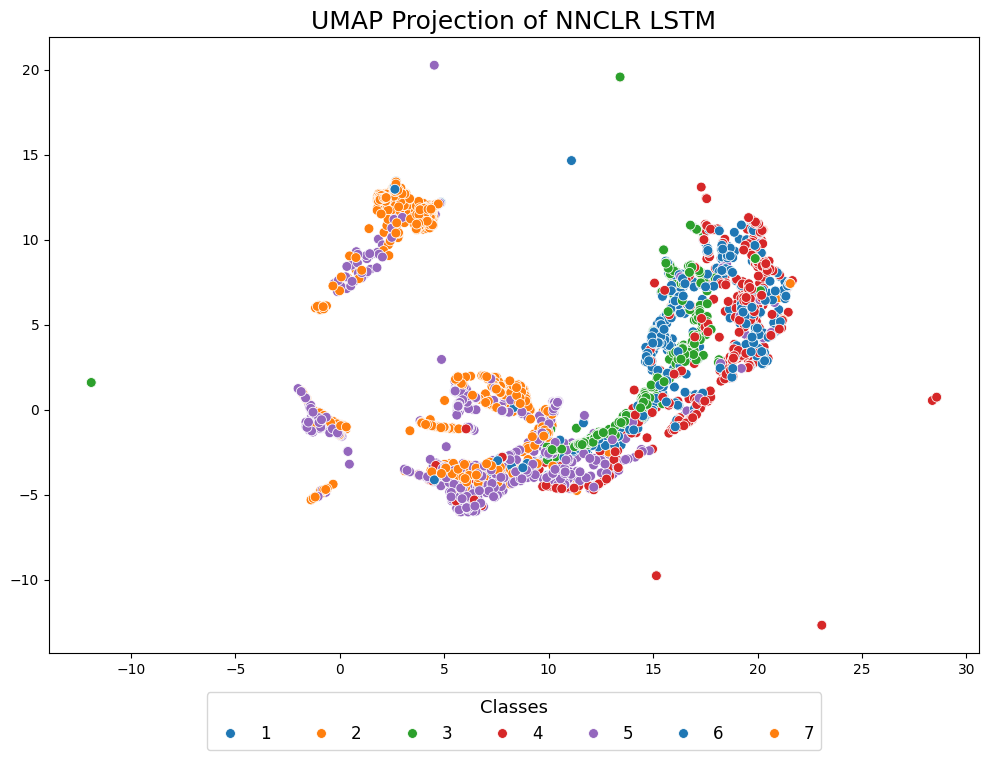

In [41]:
plt_um.umap_plt(train_nn_lstm, val_nn_lstm, test_nn_lstm, ny_train, ny_val, ny_test, 'NNCLR LSTM')

In [85]:
#nnclr_cnn embedding
t0 = time.perf_counter()
train_nn_cnn, val_nn_cnn, test_nn_cnn = nn.nnclr_lstm_embedding(train_sc, val_sc, test_sc,y_train-1,y_valid-1,y_test-1,64,5)
t1 = time.perf_counter()
elapsed_ms = (t1 - t0) * 1000
print(f"nnclr_lstm_embedding took {elapsed_ms:.1f} ms")

x_train_df shape: (8926, 96)
y_train_df shape: (8926,)
x_val_df shape: (3855, 96)
y_val_df shape: (3855,)
x_test_df shape: (3856, 96)
y_test_df shape: (3856,)


Model: "encoder_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 96, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 96, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 96, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 96, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_3          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 64)             │         8,256 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 206,400 (806.25 KB)

 Trainable params: 206,400 (806.25 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "nnclr_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ contrastive_augmenter           │ (None, None, 1)        │             0 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_augmenter        │ (None, None, 1)        │             0 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_model (Sequential)      │ (None, 64)             │       206,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ projection_head (Sequential)    │ (None, 64)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ linear_probe (Sequential)       │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 215,045 (840.02 KB)

 Trainable params: 215,045 (840.02 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
121/121 - 11s - 93ms/step - c_acc: 0.0512 - c_loss: 3.2859 - p_acc: 0.0879 - p_loss: nan - r_acc: 0.0604 - val_p_acc: 0.0864 - val_p_loss: nan
Epoch 2/20
121/121 - 5s - 37ms/step - c_acc: 0.0835 - c_loss: 3.1747 - p_acc: 0.0866 - p_loss: nan - r_acc: 0.1023 - val_p_acc: 0.0864 - val_p_loss: nan
Epoch 3/20
121/121 - 4s - 30ms/step - c_acc: 0.1063 - c_loss: 3.4160 - p_acc: 0.0866 - p_loss: nan - r_acc: 0.1302 - val_p_acc: 0.0864 - val_p_loss: nan
Epoch 4/20
121/121 - 5s - 41ms/step - c_acc: 0.1149 - c_loss: 2.9208 - p_acc: 0.0866 - p_loss: nan - r_acc: 0.1364 - val_p_acc: 0.0864 - val_p_loss: nan
Epoch 5/20
121/121 - 4s - 35ms/step - c_acc: 0.1036 - c_loss: 3.8489 - p_acc: 0.0866 - p_loss: nan - r_acc: 0.1105 - val_p_acc: 0.0864 - val_p_loss: nan
Epoch 6/20
121/121 - 4s - 29ms/step - c_acc: 0.0692 - c_loss: 3.6691 - p_acc: 0.0866 - p_loss: nan - r_acc: 0.0872 - val_p_acc: 0.0864 - val_p_loss: nan
Epoch 7/20
121/121 - 4s - 30ms/step - c_acc: 0.1149 - c_loss: 2.8714 - p_acc

In [44]:
np.savetxt('tr_ep_nn_cnn_embeddings.txt', train_nn_cnn)
np.savetxt('te_ep_nn_cnn_embeddings.txt', test_nn_cnn)
np.savetxt('vl_ep_nn_cnn_embeddings.txt', val_nn_cnn)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/content/plot_umap.py:23: UserWarning: 
The palette list has fewer values (5) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=ny_test.values.flatten(), palette=cp,s=50,hue_order=hue_order)


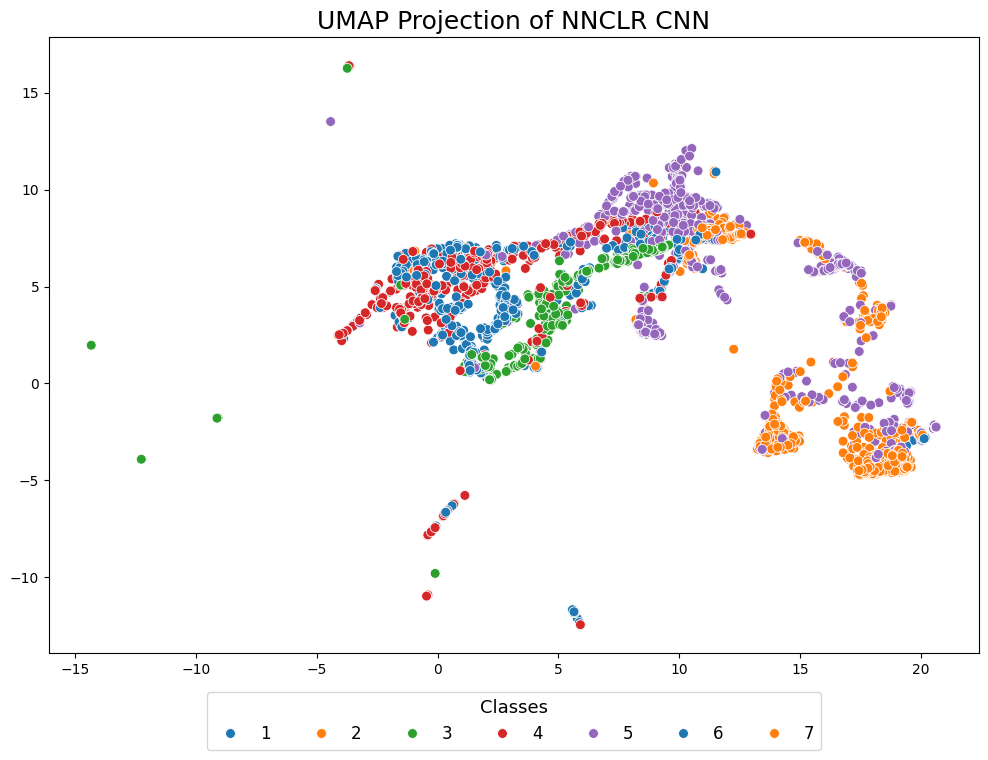

In [45]:
plt_um.umap_plt(train_nn_cnn, val_nn_cnn, test_nn_cnn, ny_train, ny_val, ny_test, 'NNCLR CNN')

In [18]:
namem="ECG5000_pca"

best_params, best_score = clasfy.optimize_LOGRG(train_wt, val_wt, test_wt,ny_train, ny_val, ny_test,namem)
print(best_params, best_score)


[I 2025-04-23 03:34:34,370] A new study created in memory with name: no-name-e96d8a2b-d660-4366-8b35-b50edf88e3a2
[I 2025-04-23 03:34:34,835] Trial 0 finished with value: 0.45317769130998703 and parameters: {'C': 0.0022428023949848494, 'fit_intercept': True, 'solver': 'saga', 'penalty': 'elasticnet', 'l1_ratio': 0.08044936615083143}. Best is trial 0 with value: 0.45317769130998703.
[I 2025-04-23 03:34:55,443] Trial 1 finished with value: 0.48923476005188066 and parameters: {'C': 29.92577841447934, 'fit_intercept': False, 'solver': 'saga', 'penalty': 'elasticnet', 'l1_ratio': 0.03515607488706696}. Best is trial 1 with value: 0.48923476005188066.
[I 2025-04-23 03:34:55,784] Trial 2 finished with value: 0.24228274967574578 and parameters: {'C': 4.08130590069781e-05, 'fit_intercept': True, 'solver': 'saga', 'penalty': 'elasticnet', 'l1_ratio': 0.07375197516718124}. Best is trial 1 with value: 0.48923476005188066.
[I 2025-04-23 03:34:56,327] Trial 3 finished with value: 0.47341115434500647 

2.5771584510803223  seconds
Classification report saved as ECG5000_pca_classification_report_2025-04-23_03-45-44.txt
{'C': 0.4731021844892997, 'fit_intercept': False, 'solver': 'saga', 'penalty': 'elasticnet', 'l1_ratio': 0.39163409663811183} 0.4927385892116183


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [19]:
best_params, best_score = clasfy.optimize_DT(train_wt, val_wt, test_wt,ny_train, ny_val, ny_test,namem)
print(best_params, best_score)


[I 2025-04-23 03:45:44,709] A new study created in memory with name: no-name-22094302-aeb6-4f1b-b8de-654c120d1eaa
[I 2025-04-23 03:45:45,657] Trial 0 finished with value: 0.5159533073929962 and parameters: {'max_depth': 9, 'criterion': 'entropy'}. Best is trial 0 with value: 0.5159533073929962.
[I 2025-04-23 03:45:46,901] Trial 1 finished with value: 0.5286640726329442 and parameters: {'max_depth': 18, 'criterion': 'log_loss'}. Best is trial 1 with value: 0.5286640726329442.
[I 2025-04-23 03:45:47,739] Trial 2 finished with value: 0.51284046692607 and parameters: {'max_depth': 23, 'criterion': 'gini'}. Best is trial 1 with value: 0.5286640726329442.
[I 2025-04-23 03:45:49,035] Trial 3 finished with value: 0.5102464332036316 and parameters: {'max_depth': 32, 'criterion': 'log_loss'}. Best is trial 1 with value: 0.5286640726329442.
[I 2025-04-23 03:45:50,346] Trial 4 finished with value: 0.5154345006485084 and parameters: {'max_depth': 26, 'criterion': 'log_loss'}. Best is trial 1 with v

1.0689685344696045  seconds
Classification report saved as ECG5000_pca_classification_report_2025-04-23_03-47-16.txt
{'max_depth': 11, 'criterion': 'log_loss'} 0.5427904564315352


In [20]:
best_params, best_score = clasfy.optimize_RF(train_wt, val_wt, test_wt,ny_train, ny_val, ny_test,namem)
print(best_params, best_score)

[I 2025-04-23 03:47:16,168] A new study created in memory with name: no-name-b51d7293-cece-4e45-a28f-278e2e37eb93
[I 2025-04-23 03:47:16,863] Trial 0 finished with value: 0.569390402075227 and parameters: {'n_estimators': 17, 'max_depth': 8}. Best is trial 0 with value: 0.569390402075227.
[I 2025-04-23 03:47:20,874] Trial 1 finished with value: 0.6378728923476005 and parameters: {'n_estimators': 57, 'max_depth': 27}. Best is trial 1 with value: 0.6378728923476005.
[I 2025-04-23 03:47:28,768] Trial 2 finished with value: 0.6365758754863813 and parameters: {'n_estimators': 111, 'max_depth': 26}. Best is trial 1 with value: 0.6378728923476005.
[I 2025-04-23 03:47:33,499] Trial 3 finished with value: 0.6274967574578469 and parameters: {'n_estimators': 67, 'max_depth': 28}. Best is trial 1 with value: 0.6378728923476005.
[I 2025-04-23 03:47:35,968] Trial 4 finished with value: 0.51284046692607 and parameters: {'n_estimators': 196, 'max_depth': 2}. Best is trial 1 with value: 0.6378728923476

5.1354053020477295  seconds
Classification report saved as ECG5000_pca_classification_report_2025-04-23_04-03-20.txt
{'n_estimators': 78, 'max_depth': 19} 0.6467842323651453


In [21]:
best_params, best_score = clasfy.optimize_KNN(train_wt, val_wt, test_wt,ny_train, ny_val, ny_test,namem)
print(best_params, best_score)


[I 2025-04-23 04:03:20,057] A new study created in memory with name: no-name-70217957-9f39-40f6-8e51-551b3dc9faca
[I 2025-04-23 04:03:22,558] Trial 0 finished with value: 0.5431906614785992 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'ball_tree'}. Best is trial 0 with value: 0.5431906614785992.
[I 2025-04-23 04:03:25,883] Trial 1 finished with value: 0.5219195849546044 and parameters: {'n_neighbors': 16, 'weights': 'distance', 'algorithm': 'kd_tree'}. Best is trial 0 with value: 0.5431906614785992.
[I 2025-04-23 04:03:28,767] Trial 2 finished with value: 0.553307392996109 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'algorithm': 'kd_tree'}. Best is trial 2 with value: 0.553307392996109.
[I 2025-04-23 04:03:32,153] Trial 3 finished with value: 0.5224383916990921 and parameters: {'n_neighbors': 16, 'weights': 'uniform', 'algorithm': 'kd_tree'}. Best is trial 2 with value: 0.553307392996109.
Exception ignored on calling ctypes callback function: <fu

0.04271221160888672  seconds
Classification report saved as ECG5000_pca_classification_report_2025-04-23_04-04-33.txt
{'n_neighbors': 2, 'weights': 'uniform', 'algorithm': 'brute'} 0.5692427385892116


In [22]:
best_params, best_score = clasfy.optimize_XGBOOST(train_pca, val_pca, test_pca,ny_train2, ny_val2, ny_test2,namem)
print(best_params, best_score)

NameError: name 'train_pca' is not defined

In [23]:

best_params, best_score = clasfy.optimize_SVM(train_wt, val_wt, test_wt,ny_train, ny_val, ny_test,namem)
print(best_params, best_score)


[I 2025-04-23 04:05:14,866] A new study created in memory with name: no-name-343c3b75-dd2b-4ddd-9201-62983f3d5f66
[I 2025-04-23 04:05:30,384] Trial 0 finished with value: 0.5076523994811932 and parameters: {'C': 0.6, 'kernel': 'linear', 'degree': 2, 'gamma': 'scale'}. Best is trial 0 with value: 0.5076523994811932.
[I 2025-04-23 04:05:36,706] Trial 1 finished with value: 0.5481193255512322 and parameters: {'C': 0.1, 'kernel': 'rbf', 'degree': 4, 'gamma': 'scale'}. Best is trial 1 with value: 0.5481193255512322.
[I 2025-04-23 04:05:42,241] Trial 2 finished with value: 0.6298313878080415 and parameters: {'C': 1, 'kernel': 'rbf', 'degree': 5, 'gamma': 'auto'}. Best is trial 2 with value: 0.6298313878080415.
[I 2025-04-23 04:05:52,680] Trial 3 finished with value: 0.5073929961089494 and parameters: {'C': 0.3, 'kernel': 'linear', 'degree': 3, 'gamma': 'scale'}. Best is trial 2 with value: 0.6298313878080415.
[I 2025-04-23 04:05:59,191] Trial 4 finished with value: 0.5055771725032425 and par

5.535032749176025  seconds
Classification report saved as ECG5000_pca_classification_report_2025-04-23_04-16-56.txt
{'C': 1, 'kernel': 'rbf', 'degree': 5, 'gamma': 'auto'} 0.6351141078838174


In [24]:
best_params, best_score = clasfy2.optimize_NB(train_wt, val_wt, test_wt,ny_train, ny_val, ny_test,namem)
print(best_params, best_score)


[I 2025-04-23 04:16:56,954] A new study created in memory with name: no-name-a9a1a50b-2718-4971-9484-0a305c8eebc5
[I 2025-04-23 04:16:56,970] Trial 0 finished with value: 0.4920881971465629 and parameters: {'var_smoothing': 1.6344943745279737e-05}. Best is trial 0 with value: 0.4920881971465629.
[I 2025-04-23 04:16:56,984] Trial 1 finished with value: 0.49182879377431904 and parameters: {'var_smoothing': 0.00026116707927781947}. Best is trial 0 with value: 0.4920881971465629.
[I 2025-04-23 04:16:56,997] Trial 2 finished with value: 0.4920881971465629 and parameters: {'var_smoothing': 1.4901648094684224e-12}. Best is trial 0 with value: 0.4920881971465629.
[I 2025-04-23 04:16:57,010] Trial 3 finished with value: 0.4920881971465629 and parameters: {'var_smoothing': 1.1653932855407312e-10}. Best is trial 0 with value: 0.4920881971465629.
[I 2025-04-23 04:16:57,024] Trial 4 finished with value: 0.4920881971465629 and parameters: {'var_smoothing': 7.644564064930526e-10}. Best is trial 0 wit

Best hyperparameters:  {'var_smoothing': 0.007944912767124003}
Best validation accuracy:  0.4931258106355383
Test accuracy: 0.512707468879668
Time taken: 0.012520313262939453 seconds
Classification report saved as ECG5000_pca_classification_report_2025-04-23_04-16-58.txt
{'var_smoothing': 0.007944912767124003} 0.512707468879668


In [68]:
!pip install scikit-learn==1.1.3
